In [1]:

import dgl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_backtest import annualized_sharpe_ratio, annualized_sortino_ratio, \
    annualized_max_drawdown, annualized_calmar_ratio
from utils_distance_correlation import df_distance_correlation

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [3]:
METHOD = 'pct'
CORR_METHOD = 'pearson'
THRESHOLD = 0.5

## Read in Data

In [4]:
sp500_hist = pd.read_csv(
    "./data/sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

sp500_hist = sp500_hist.loc['2014-01-01':,]
sp500_hist.dropna(axis=1, inplace=True)


print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (2266, 470)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.141602,23.907921,101.185295,17.388981,35.240082,60.504734,31.847378,19.123333,68.658348,59.290001,...,169.137527,20.609207,66.582367,44.643036,30.301586,45.261662,83.170258,53.180000,24.822664,30.329689
2014-01-03,37.610752,25.020359,104.080498,17.007023,35.457024,60.548027,32.188923,18.756666,68.886833,59.160000,...,167.479828,20.601709,66.422142,44.857124,30.576576,45.544949,83.530914,53.580002,24.998468,30.039131
2014-01-06,37.425739,25.482304,103.084709,17.099760,34.162140,60.331593,32.613773,18.580000,68.159042,58.119999,...,167.360214,20.489336,66.522278,44.587177,30.523350,45.508789,84.071892,53.400002,24.822664,29.973518
2014-01-07,37.960957,25.369169,104.357124,16.977465,34.229923,60.989532,32.363853,18.586666,68.988396,58.970001,...,172.188049,20.841444,67.463448,45.276005,30.612062,46.147724,85.749016,53.950001,24.898008,30.085989
2014-01-08,38.582062,26.047947,103.545738,17.084980,34.141792,61.586887,32.655426,18.476667,69.521561,58.900002,...,175.417999,20.759035,67.243179,45.359783,30.594316,46.129646,87.849907,53.910000,25.115677,29.748577


### S&P500 as Benchmark

In [5]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
2014-01-08    1837.489990
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2265, dtype: float64

In [6]:
TRAIN_START_DATE, TRAIN_END_DATE = "2014-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2021-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1258, 470)
Validation shape: (505, 470)
Test shape: (503, 470)


In [7]:
df_train

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.141602,23.907921,101.185295,17.388981,35.240082,60.504734,31.847378,19.123333,68.658348,59.290001,...,169.137527,20.609207,66.582367,44.643036,30.301586,45.261662,83.170258,53.180000,24.822664,30.329689
2014-01-03,37.610752,25.020359,104.080498,17.007023,35.457024,60.548027,32.188923,18.756666,68.886833,59.160000,...,167.479828,20.601709,66.422142,44.857124,30.576576,45.544949,83.530914,53.580002,24.998468,30.039131
2014-01-06,37.425739,25.482304,103.084709,17.099760,34.162140,60.331593,32.613773,18.580000,68.159042,58.119999,...,167.360214,20.489336,66.522278,44.587177,30.523350,45.508789,84.071892,53.400002,24.822664,29.973518
2014-01-07,37.960957,25.369169,104.357124,16.977465,34.229923,60.989532,32.363853,18.586666,68.988396,58.970001,...,172.188049,20.841444,67.463448,45.276005,30.612062,46.147724,85.749016,53.950001,24.898008,30.085989
2014-01-08,38.582062,26.047947,103.545738,17.084980,34.141792,61.586887,32.655426,18.476667,69.521561,58.900002,...,175.417999,20.759035,67.243179,45.359783,30.594316,46.129646,87.849907,53.910000,25.115677,29.748577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,60.658115,29.247074,138.501755,35.375175,68.045486,66.140617,60.909603,24.799999,125.596710,205.160004,...,88.352982,42.943733,52.057148,33.934464,58.313515,80.661499,91.214142,142.899994,33.992252,77.151306
2018-12-26,63.435974,31.776182,144.184326,37.866352,71.991089,68.271782,64.681641,25.920000,130.614197,222.949997,...,95.286011,43.792011,54.544388,35.590034,61.059139,83.414490,95.707779,152.520004,35.757629,80.693588
2018-12-27,64.345779,31.530161,143.868149,37.620605,72.694519,68.729797,65.619980,26.540001,131.929657,225.139999,...,94.220131,44.165985,54.782780,35.607304,62.085175,84.313622,95.641960,155.350006,35.713490,82.065712


### Build correlation matrix

In [8]:
df_train_pct = df_train.pct_change()
df_train_pct = df_train_pct.iloc[1:]

assert df_train_pct.isnull().any

df_train_pct

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.012631,0.046530,0.028613,-0.021966,0.006156,0.000716,0.010724,-0.019174,0.003328,-0.002193,...,-0.009801,-0.000364,-0.002406,0.004796,0.009075,0.006259,0.004336,0.007522,0.007082,-0.009580
2014-01-06,-0.004919,0.018463,-0.009567,0.005453,-0.036520,-0.003575,0.013199,-0.009419,-0.010565,-0.017579,...,-0.000714,-0.005455,0.001508,-0.006018,-0.001741,-0.000794,0.006476,-0.003359,-0.007033,-0.002184
2014-01-07,0.014301,-0.004440,0.012343,-0.007152,0.001984,0.010905,-0.007663,0.000359,0.012168,0.014625,...,0.028847,0.017185,0.014148,0.015449,0.002906,0.014040,0.019949,0.010300,0.003035,0.003752
2014-01-08,0.016362,0.026756,-0.007775,0.006333,-0.002575,0.009794,0.009009,-0.005918,0.007728,-0.001187,...,0.018758,-0.003954,-0.003265,0.001850,-0.000580,-0.000392,0.024500,-0.000741,0.008742,-0.011215
2014-01-09,0.000343,0.064785,0.011131,-0.012770,0.017077,0.003374,0.001786,0.009020,0.009738,0.003226,...,-0.002533,0.003970,-0.009728,0.003694,0.004059,-0.019339,-0.009853,0.004637,0.007333,0.006931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.009796,-0.034438,-0.016445,-0.025874,-0.008950,-0.016949,-0.025420,-0.029354,-0.025729,-0.017433,...,-0.014988,-0.045187,-0.038315,-0.005330,-0.032472,-0.012707,-0.021634,-0.022906,-0.014081,-0.029383
2018-12-26,0.045795,0.086474,0.041029,0.070422,0.057985,0.032222,0.061928,0.045161,0.039949,0.086713,...,0.078470,0.019753,0.047779,0.048787,0.047084,0.034130,0.049265,0.067320,0.051935,0.045913
2018-12-27,0.014342,-0.007742,-0.002193,-0.006490,0.009771,0.006709,0.014507,0.023920,0.010071,0.009823,...,-0.011186,0.008540,0.004371,0.000485,0.016804,0.010779,-0.000688,0.018555,-0.001234,0.017004


In [9]:
# if METHOD == 'standard':
#     df_corr = df_train.corr(method=CORR_METHOD).abs()
# elif METHOD == 'pct':
#     df_train_pct = df_train.pct_change()
#     df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
# elif METHOD == 'pct_yearly':
#     df_train_pct = df_train.pct_change()
#     df_train_pct = df_train_pct.groupby(df_train_pct.index.year).sum()
#     df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
# elif METHOD == 'drawdown':
#     df_mdd = df_train.apply(lambda x: drawdown(x))
#     df_corr = df_mdd.corr(method=CORR_METHOD).abs()
# else:
#     raise KeyError("METHOD must be either 'standard', 'pct' or 'pct_yearly'.")

df_corr = df_distance_correlation(
    df_train=df_train_pct, 
    stocks=df_train_pct.columns.to_list())
df_corr.to_csv('./data/correlation_matrix_dcor.csv')

df_corr

100%|██████████| 470/470 [02:07<00:00,  3.69it/s]


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.0,0.370769,0.28032,0.406274,0.441936,0.340056,0.550617,0.315125,0.554897,0.510059,...,0.338717,0.133907,0.384667,0.451648,0.518916,0.420439,0.503341,0.459211,0.419441,0.47887
AAL,0.370769,1.0,0.252693,0.268759,0.241136,0.282556,0.322013,0.272014,0.317689,0.327121,...,0.238032,0.059439,0.161157,0.291753,0.314876,0.306836,0.306738,0.331425,0.32306,0.295755
AAP,0.28032,0.252693,1.0,0.21471,0.242787,0.258569,0.302253,0.239381,0.293609,0.262833,...,0.152884,0.128376,0.221394,0.269603,0.272197,0.297626,0.267731,0.250553,0.321172,0.242498
AAPL,0.406274,0.268759,0.21471,1.0,0.272596,0.240476,0.389665,0.240751,0.422469,0.445344,...,0.279031,0.113409,0.302957,0.309033,0.330494,0.341278,0.348092,0.364536,0.288075,0.346662
ABBV,0.441936,0.241136,0.242787,0.272596,1.0,0.377955,0.498962,0.22688,0.371773,0.352876,...,0.259885,0.165061,0.287647,0.370497,0.334443,0.299893,0.442624,0.322106,0.271527,0.457464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.420439,0.306836,0.297626,0.341278,0.299893,0.259019,0.403776,0.315439,0.4282,0.440136,...,0.284417,0.196093,0.316925,0.322706,0.393629,1.0,0.377104,0.320422,0.348723,0.371764
ZBH,0.503341,0.306738,0.267731,0.348092,0.442624,0.391303,0.550508,0.307244,0.451153,0.432898,...,0.290739,0.155755,0.336509,0.450987,0.40521,0.377104,1.0,0.352122,0.351422,0.42747
ZBRA,0.459211,0.331425,0.250553,0.364536,0.322106,0.266214,0.380782,0.236574,0.386571,0.406202,...,0.332578,0.078046,0.31039,0.28024,0.417302,0.320422,0.352122,1.0,0.34108,0.383822
ZION,0.419441,0.32306,0.321172,0.288075,0.271527,0.256212,0.370537,0.370614,0.390556,0.324931,...,0.24792,0.084798,0.359999,0.300823,0.426909,0.348723,0.351422,0.34108,1.0,0.304016


In [10]:
df_corr.quantile(0.5).mean()

0.31667385642044543

In [11]:
STOCK_NAMES = df_corr.columns.values

## Build Graph

In [12]:
df_corr.where(df_corr >= THRESHOLD).count().sum()

10264

In [13]:
nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=THRESHOLD
)

# assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'
assert (df_corr.where(df_corr >= THRESHOLD).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

In [14]:
len(nx_graph.edges)

4897

### Plot degree distribution

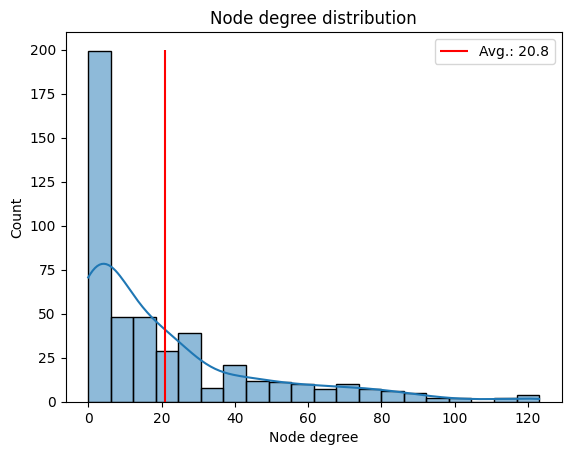

In [15]:
degrees = [degree for (node, degree) in nx_graph.degree()]
avg_degree = sum(degrees) / len(degrees)

sns.histplot(degrees, kde=True)
plt.vlines(avg_degree, ymin=0, ymax=200, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.legend()
plt.show()

### Build Q matrix

In [16]:
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

### Visualize graph

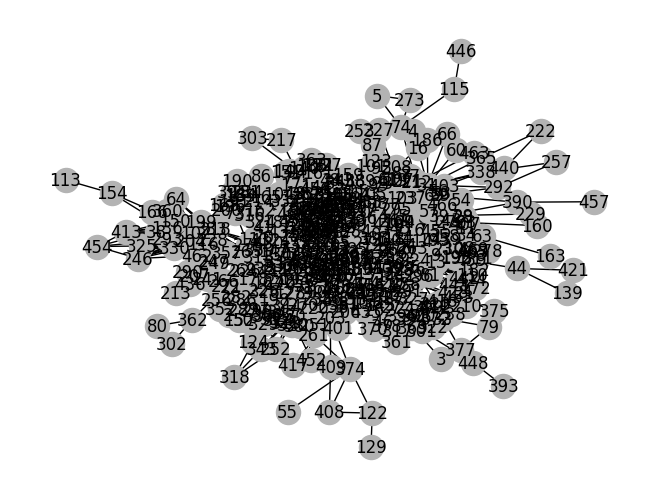

In [17]:
if len(nx_graph.nodes) < 500:
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Set up GNN

In [18]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 30000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [19]:
n = len(nx_graph.nodes)

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [20]:
print('Running GNN...')
gnn_start = time()

net, embed, optimizer = get_gnn(
    n_nodes=n, 
    params=params, 
    model_type=params["model"], 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)   
    
net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
    q_torch=q_torch, 
    dgl_graph=graph_dgl, 
    net=net, 
    embed=embed, 
    optimizer=optimizer, 
    number_epochs=params['number_epochs'],
    tol=params['tolerance'], 
    patience=params['patience'], 
    prob_threshold=params['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -15.54034423828125
Epoch: 1000, Loss: -89.91650390625
Epoch: 2000, Loss: -122.21359252929688
Epoch: 3000, Loss: -137.57940673828125
Epoch: 4000, Loss: -133.0291748046875
Epoch: 5000, Loss: -138.5677490234375
Epoch: 6000, Loss: -141.70533752441406
Epoch: 7000, Loss: -134.85446166992188
Epoch: 8000, Loss: -154.48565673828125
Epoch: 9000, Loss: -140.6508026123047
Epoch: 10000, Loss: -149.31040954589844
Epoch: 11000, Loss: -146.94589233398438
Epoch: 12000, Loss: -158.22726440429688
Epoch: 13000, Loss: -159.44178771972656
Epoch: 14000, Loss: -163.9352264404297
Epoch: 15000, Loss: -163.35108947753906
Epoch: 16000, Loss: -167.14752197265625
Epoch: 17000, Loss: -161.34674072265625
Epoch: 18000, Loss: -162.425048828125
Epoch: 19000, Loss: -166.25384521484375
Epoch: 20000, Loss: -167.8386688232422
Epoch: 21000, Loss: -166.46632385253906
Epoch: 22000, Loss: -166.71934509277344
Epoch: 23000, Loss: -167.45623779296875
Epoch: 24000, Loss: -167.84671020507812
Epoch: 250

## Post-process GNN Results

In [21]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis_gnn} with {number_violations_gnn} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 170 with 0 violations
Took 214.641s, model training took 214.533s


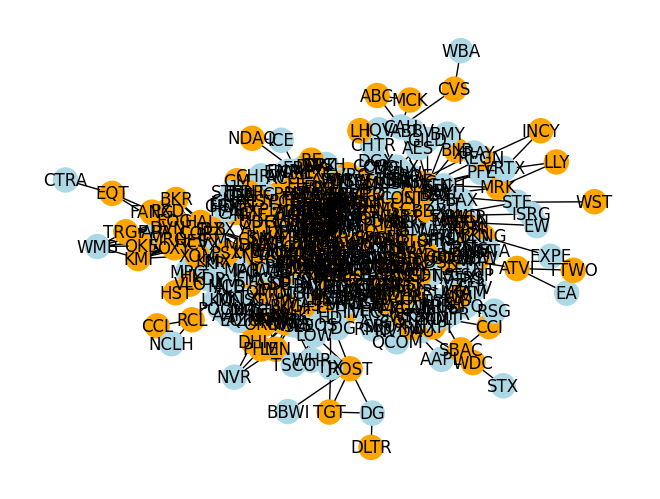

In [22]:
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [23]:
gnn_mis_set = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

## Compare against traditional solver

In [24]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 161 with 0 violations.
MIS solver took 10.076s


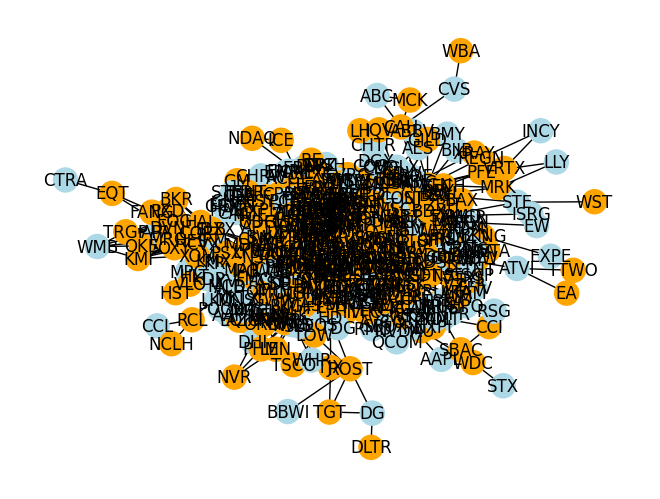

In [25]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [26]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

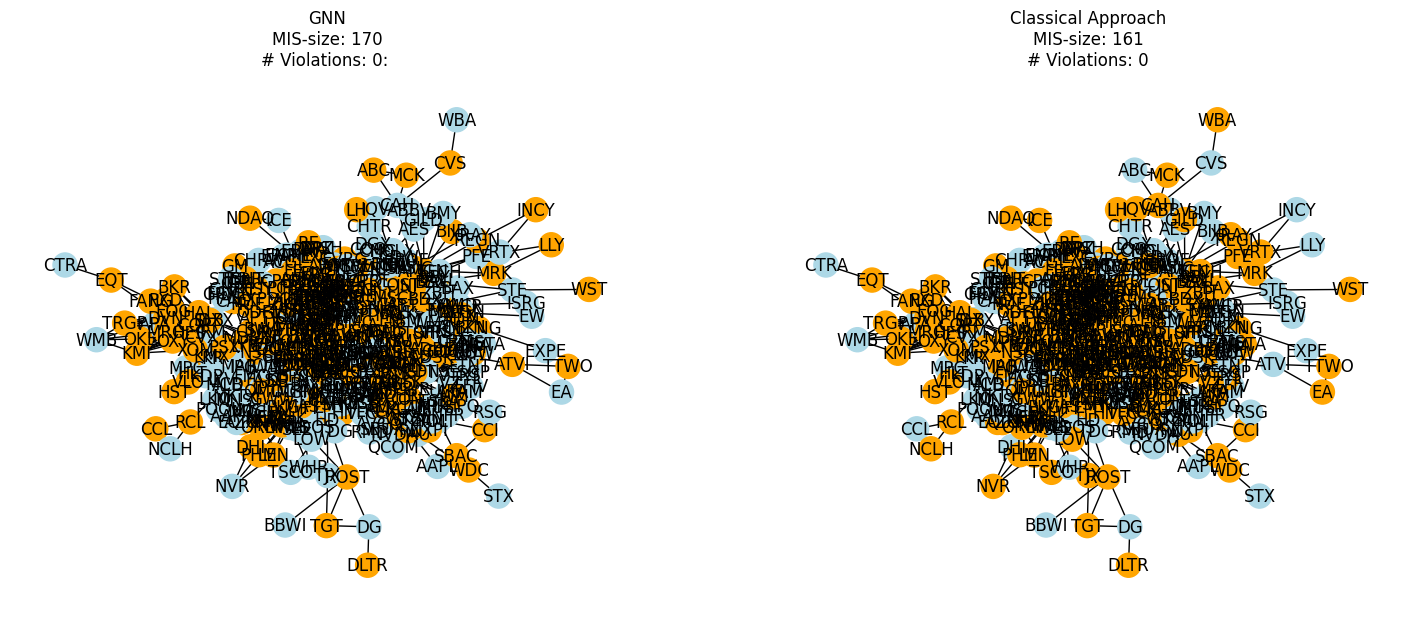

In [27]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# GNN
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax0)
ax0.set_title(f"GNN\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

In [28]:
df_mis = pd.concat([
    pd.DataFrame(
        data={'gnn': gnn_mis_set},
        index=gnn_mis_set
    ),
    pd.DataFrame(
        data={'solver': solver_mis_set},
        index=solver_mis_set
    )
],
axis=1)

len(df_mis)

213

In [29]:
# intersection
df_intersec = df_mis.dropna(axis=0)
print(f"Length: {len(df_intersec)}")
# df_intersec

Length: 118


In [30]:
len(df_intersec) / ((size_mis_gnn.item() + ind_set_nx_size) /2 )

0.7129909365558912

In [31]:
# Not intersecting
df_non_intersec = df_mis.drop(index=df_intersec.index)
print(f"Length: {len(df_non_intersec)}")
# df_non_intersec

Length: 95


## Backtest

In [32]:
RISK_FREE_RATE = 0.01

In [33]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

### Training

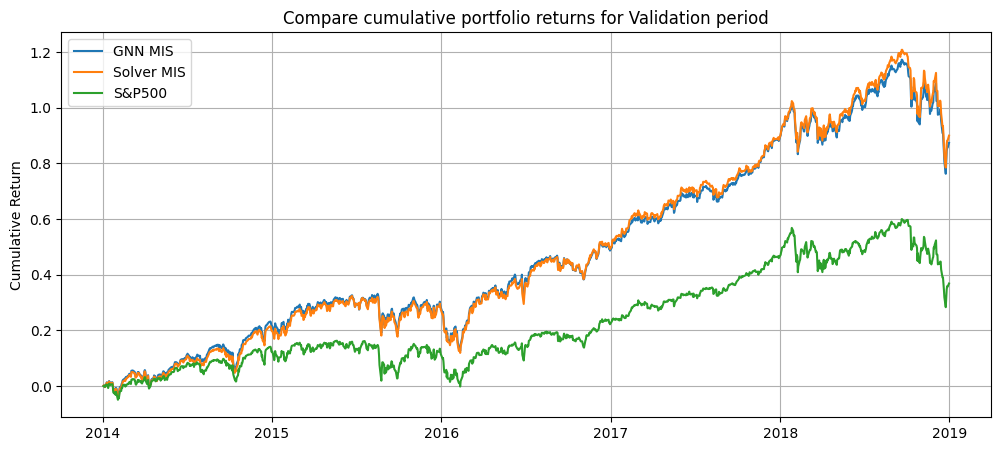

In [34]:
# GNN MIS Portfolio
gnn_mis_returns_train, gnn_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_train, solver_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_train = gspc_train.pct_change()
gspc_returns_cum_train = (gspc_returns_train + 1).cumprod() -1

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_train, label="GNN MIS")
plt.plot(solver_mis_returns_cum_train, label="Solver MIS")
plt.plot(gspc_returns_cum_train, label="S&P500")

plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

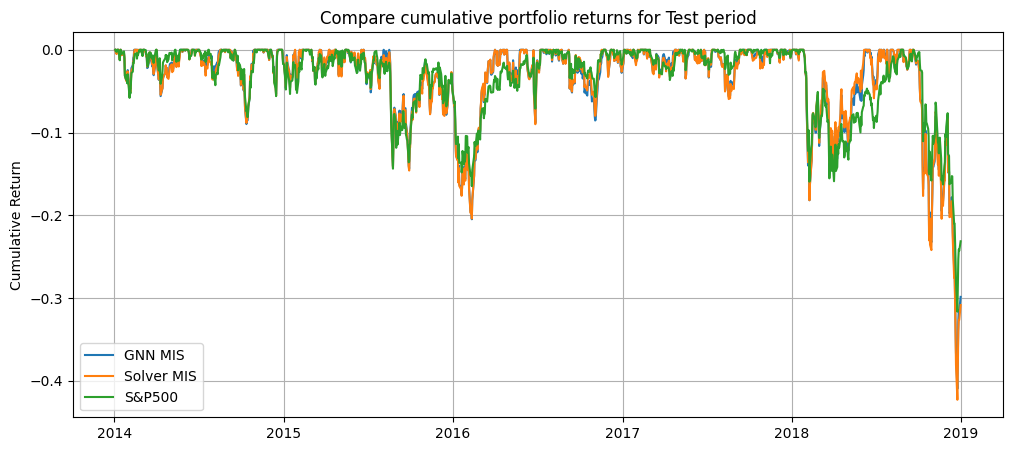

In [35]:
gnn_mis_mdd_train = drawdown_pct(gnn_mis_returns_cum_train)
solver_mis_mdd_train = drawdown_pct(solver_mis_returns_cum_train)
gspc_mdd_train = drawdown_pct(gspc_returns_cum_train)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_train, label="GNN MIS")
plt.plot(solver_mis_mdd_train, label="Solver MIS")
plt.plot(gspc_mdd_train, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [36]:
# Sharpe Ratios
df_sharpe_train = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sharpe_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sharpe_train['Avg'] = df_sharpe_train.mean(axis=1)
# df_sharpe_train.index.rename('Sharpe', inplace=True)
df_sharpe_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_train.index), df_sharpe_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_train.index = multi_idx
df_sharpe_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                    
Sharpe GNN        1.60  0.36  1.00  3.00 -0.00  1.19
       Classic    1.49  0.42  1.05  2.94  0.07  1.19
       SP500      1.00 -0.03  0.68  2.54 -0.35  0.77

In [37]:
# Sortino Ratios
df_sortino_train = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sortino_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sortino_train['Avg'] = df_sortino_train.mean(axis=1)
# df_sortino_train.index.rename('Sortino', inplace=True)
df_sortino_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_train.index), df_sortino_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_train.index = multi_idx
df_sortino_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric  Portfolio                                    
Sortino GNN        2.09  0.52  1.31  4.33 -0.00  1.65
        Classic    1.95  0.60  1.36  4.20  0.09  1.64
        SP500      1.30 -0.05  0.89  3.41 -0.43  1.03

In [38]:
# Maximal Draw Down
df_mdd_train = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_returns_train, name='GNN'),
    annualized_max_drawdown(df_returns=solver_mis_returns_train, name='Classic'),
    annualized_max_drawdown(df_returns=gspc_returns_train, name='SP500')
], axis=1).T

df_mdd_train['Avg'] = df_mdd_train.mean(axis=1)
# df_mdd_train.index.rename('MDD', inplace=True)
df_mdd_train.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_train.index), df_mdd_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_train.index = multi_idx
df_mdd_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                    
MDD    GNN       -0.09 -0.14 -0.20 -0.06 -0.41 -0.18
       Classic   -0.09 -0.15 -0.20 -0.06 -0.42 -0.18
       SP500     -0.08 -0.14 -0.16 -0.04 -0.32 -0.15

In [39]:
# Calmar Ratios
df_calmar_train = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_calmar_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_calmar_train['Avg'] = df_calmar_train.mean(axis=1)
# df_calmar_train.index.rename('Calmar', inplace=True)
df_calmar_train.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_train.index), df_calmar_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_train.index = multi_idx
df_calmar_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                    
Calmar GNN        2.15  0.39  0.72  4.03 -0.00  1.46
       Classic    2.03  0.44  0.77  3.80  0.03  1.41
       SP500      1.39 -0.04  0.54  4.64 -0.19  1.27

### Validation

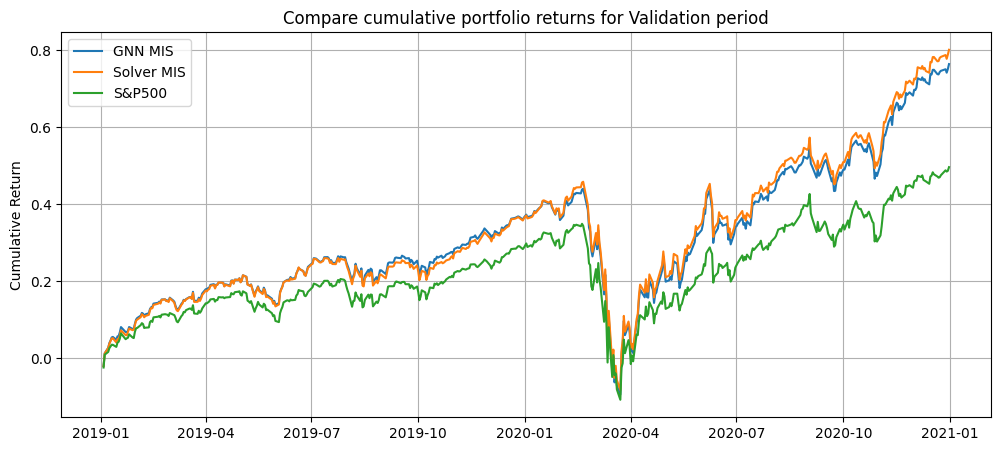

In [40]:
# GNN MIS Portfolio
gnn_mis_returns_val, gnn_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = (gspc_returns_val + 1).cumprod() -1

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_val, label="GNN MIS")
plt.plot(solver_mis_returns_cum_val, label="Solver MIS")
plt.plot(gspc_returns_cum_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

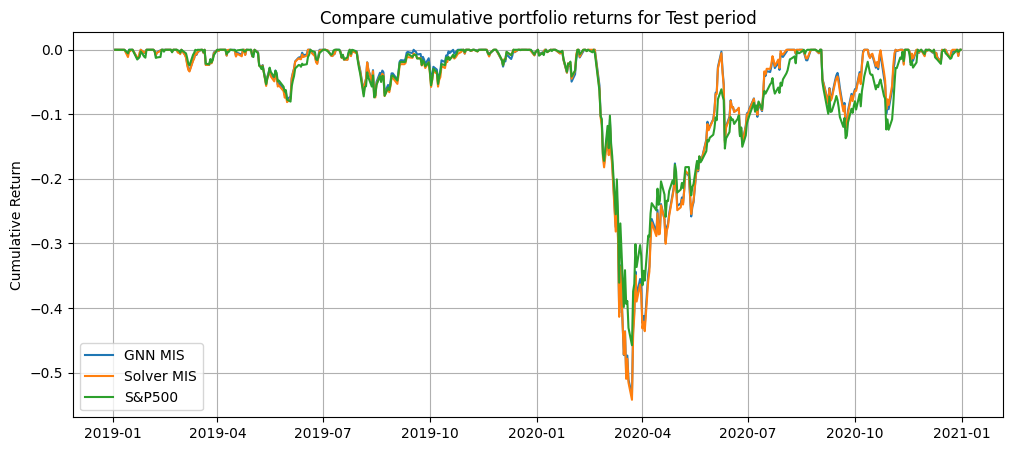

In [41]:
gnn_mis_mdd_val = drawdown_pct(gnn_mis_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)
gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_val, label="GNN MIS")
plt.plot(solver_mis_mdd_val, label="Solver MIS")
plt.plot(gspc_mdd_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [42]:
# Sharpe Ratios
df_sharpe_val = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sharpe_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sharpe_val['Avg'] = df_sharpe_val.mean(axis=1)
df_sharpe_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_val.index), df_sharpe_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_val.index = multi_idx
df_sharpe_val.round(2)

2019  2020   Avg
Metric Portfolio                  
Sharpe GNN        2.43  0.86  1.65
       Classic    2.37  0.93  1.65
       SP500      2.01  0.58  1.29

In [43]:
# Sortino Ratios
df_sortino_val = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sortino_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sortino_val['Avg'] = df_sortino_val.mean(axis=1)
df_sortino_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_val.index), df_sortino_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_val.index = multi_idx
df_sortino_val.round(2)

2019  2020   Avg
Metric  Portfolio                  
Sortino GNN        3.15  0.96  2.05
        Classic    3.06  1.02  2.04
        SP500      2.48  0.66  1.57

In [44]:
# Maximal Draw Down
df_mdd_val = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_returns_val, name='GNN'),
    annualized_max_drawdown(df_returns=solver_mis_returns_val, name='Classic'),
    annualized_max_drawdown(df_returns=gspc_returns_val, name='SP500')
], axis=1).T

df_mdd_val['Avg'] = df_mdd_val.mean(axis=1)
df_mdd_val.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_val.index), df_mdd_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_val.index = multi_idx
df_mdd_val.round(2)

2019  2020   Avg
Metric Portfolio                  
MDD    GNN       -0.08 -0.54 -0.31
       Classic   -0.08 -0.54 -0.31
       SP500     -0.08 -0.46 -0.27

In [45]:
# Calmar Ratios
df_calmar_val = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_calmar_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_calmar_val['Avg'] = df_calmar_val.mean(axis=1)
df_calmar_val.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_val.index), df_calmar_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_val.index = multi_idx
df_calmar_val.round(2)

2019  2020   Avg
Metric Portfolio                  
Calmar GNN        4.04  0.58  2.31
       Classic    3.80  0.62  2.21
       SP500      3.12  0.44  1.78

### Test

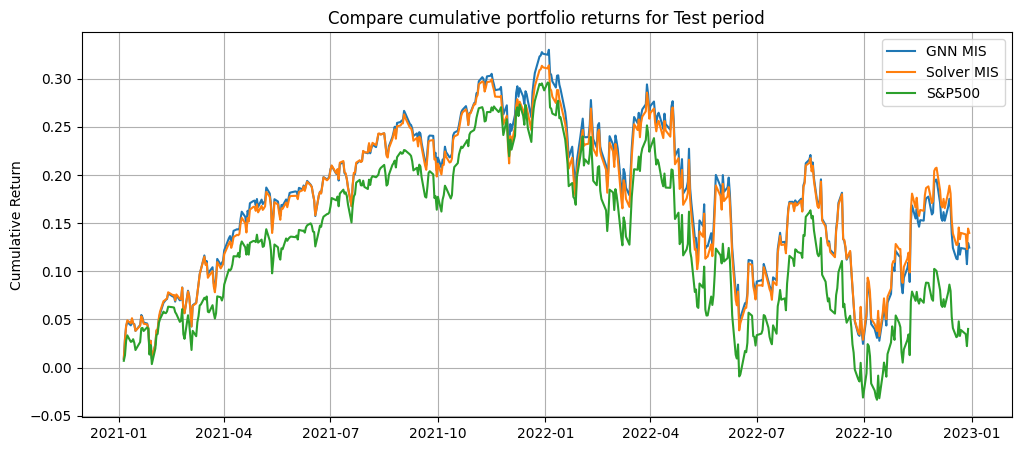

In [46]:
# GNN MIS Portfolio
gnn_mis_returns_test, gnn_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = (gspc_returns_test + 1).cumprod() -1

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_test, label="GNN MIS")
plt.plot(solver_mis_returns_cum_test, label="Solver MIS")
plt.plot(gspc_returns_cum_test, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

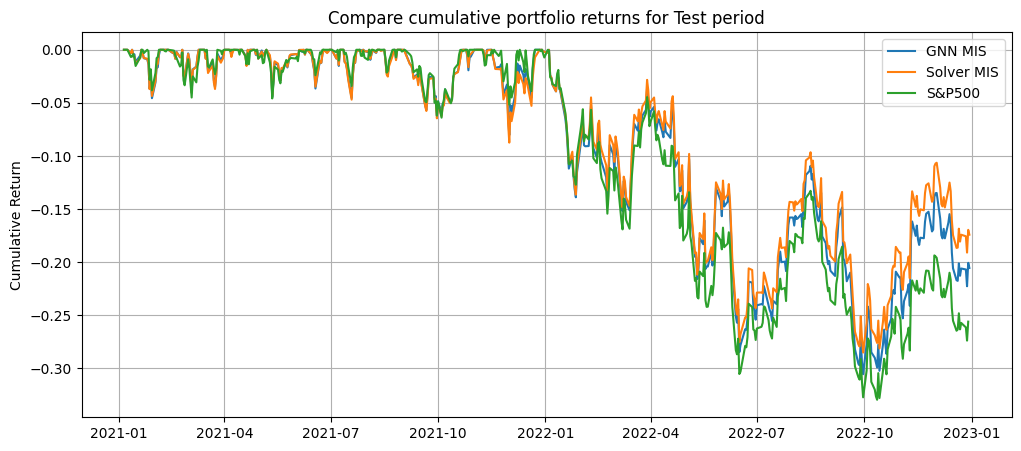

In [47]:
gnn_mis_mdd_test = drawdown_pct(gnn_mis_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)
gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_test, label="GNN MIS")
plt.plot(solver_mis_mdd_test, label="Solver MIS")
plt.plot(gspc_mdd_test, label="S&P500")
# plt.hlines(0, xmin=gnn_mis_mdd_test.index[0], xmax=gnn_mis_mdd_test.index[-1])
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [48]:
# Sharpe Ratios
df_sharpe_test = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sharpe_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sharpe_test['Avg'] = df_sharpe_test.mean(axis=1)
df_sharpe_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_test.index), df_sharpe_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_test.index = multi_idx
df_sharpe_test.round(2)

2021  2022   Avg
Metric Portfolio                  
Sharpe GNN        2.11 -0.61  0.75
       Classic    2.02 -0.50  0.76
       SP500      1.93 -0.81  0.56

In [49]:
# Sortino Ratios
df_sortino_test = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sortino_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sortino_test['Avg'] = df_sortino_test.mean(axis=1)
df_sortino_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_test.index), df_sortino_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_test.index = multi_idx
df_sortino_test.round(2)

2021  2022   Avg
Metric  Portfolio                  
Sortino GNN        3.13 -1.01  1.06
        Classic    2.96 -0.82  1.07
        SP500      2.75 -1.29  0.73

In [50]:
# Maximal Draw Down
df_mdd_test = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_returns_test, name='GNN'),
    annualized_max_drawdown(df_returns=solver_mis_returns_test, name='Classic'),
    annualized_max_drawdown(df_returns=gspc_returns_test, name='SP500')
], axis=1).T

df_mdd_test['Avg'] = df_mdd_test.mean(axis=1)
df_mdd_test.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_test.index), df_mdd_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_test.index = multi_idx
df_mdd_test.round(2)

2021  2022   Avg
Metric Portfolio                  
MDD    GNN       -0.08 -0.31 -0.19
       Classic   -0.09 -0.29 -0.19
       SP500     -0.06 -0.33 -0.20

In [51]:
# Calmar Ratios
df_calmar_test = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_calmar_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_calmar_test['Avg'] = df_calmar_test.mean(axis=1)
df_calmar_test.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_test.index), df_calmar_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_test.index = multi_idx
df_calmar_test.round(2)

2021  2022   Avg
Metric Portfolio                  
Calmar GNN        3.50 -0.48  1.51
       Classic    3.09 -0.42  1.33
       SP500      3.94 -0.59  1.67